In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv('train.csv')

In [3]:
df.head()

,ID,Customer_ID,Month,Name,Age,SSN,Occupation,Annual_Income,Monthly_Inhand_Salary,Num_Bank_Accounts,...,Credit_Mix,Outstanding_Debt,Credit_Utilization_Ratio,Credit_History_Age,Payment_of_Min_Amount,Total_EMI_per_month,Amount_invested_monthly,Payment_Behaviour,Monthly_Balance,Credit_Score
0,5634,3392,1,Aaron Maashoh,23.0,821000265.0,Scientist,19114.12,1824.843333,3.0,...,Good,809.98,26.822620,265.0,No,49.574949,21.46538,High_spent_Small_value_payments,312.494089,Good
1,5635,3392,2,Aaron Maashoh,23.0,821000265.0,Scientist,19114.12,1824.843333,3.0,...,Good,809.98,31.944960,266.0,No,49.574949,21.46538,Low_spent_Large_value_payments,284.629162,Good
2,5636,3392,3,Aaron Maashoh,23.0,821000265.0,Scientist,19114.12,1824.843333,3.0,...,Good,809.98,28.609352,267.0,No,49.574949,21.46538,Low_spent_Medium_value_payments,331.209863,Good
3,5637,3392,4,Aaron Maashoh,23.0,821000265.0,Scientist,19114.12,1824.843333,3.0,...,Good,809.98,31.377862,268.0,No,49.574949,21.46538,Low_spent_Small_value_payments,223.451310,Good
4,5638,3392,5,Aaron Maashoh,23.0,821000265.0,Scientist,19114.12,1824.843333,3.0,...,Good,809.98,24.797347,269.0,No,49.574949,21.46538,High_spent_Medium_value_payments,341.489231,Good


## Description of Dataset

**Finding how many unique values the categorical columns have:**

In [4]:
object_cols = df.select_dtypes(include='object').columns.tolist()

unique_value_counts = [(col, df[col].nunique()) for col in object_cols]
unique_value_counts_df = pd.DataFrame(unique_value_counts, columns=['Column', 'Num_Unique_Values'])

unique_value_counts_df.head()

,Column,Num_Unique_Values
0,Name,10128
1,Occupation,15
2,Type_of_Loan,6261
3,Credit_Mix,3
4,Payment_of_Min_Amount,3


I can implement Feature Engineering and add a column that showcases how many months a client has had an account for. 

In [5]:
# Number of Unique Customers
num_unique_customers = df.Customer_ID.nunique()
print("There are", num_unique_customers, "unique customers in the dataset.")

There are 12500 unique customers in the dataset.


**There are many repeating customer_ID, which can skew the data if a customer appears too often. Therefore, here we will how many credit score have changed:**

In [6]:
# Sort the dataframe by customer ID and month
df2 = df.sort_values(['Customer_ID', 'Month'])

# Create a new column called 'Previous_Credit_Score' that contains the credit score from the previous month
df2['Previous_Credit_Score'] = df2.groupby('Customer_ID')['Credit_Score'].shift(1)

# Drop rows where there is no previous credit score (i.e., the first month for each customer)
df2 = df2.dropna(subset=['Previous_Credit_Score'])

# Calculate the number of customers whose credit score has changed
num_customers_changed = sum(df2['Credit_Score'] != df2['Previous_Credit_Score'])

# Print the number of customers whose credit score has changed
print('Number of customers whose credit score has changed:', num_customers_changed)

# Create a new dataframe that contains only the rows where the credit score has changed
df_changed = df2[df2['Credit_Score'] != df2['Previous_Credit_Score']]

Number of customers whose credit score has changed: 15294


**Now we will explore how often a customer has had their credit score change, so that we can ensure their are no outliers:**

In [7]:
# Calculate the number of times each customer's credit score has changed
change_counts = df.groupby('Customer_ID')['Credit_Score'].apply(lambda x: (x != x.shift()).sum()).reset_index(name='Change_Count')

# Filter out customers whose credit score has changed less than or equal to 2 times
change_counts = change_counts[change_counts['Change_Count'] > 2]

# Print the resulting dataframe
# change_counts.sort_values(['Change_Count'])

- We see that the number of credit score changes per customer is at most 6, and more than 4305 customers have changed their credit score more than 2 times.

**Finding the min/max of each column** - Want to compare numerical values to the dependent value - Credit Score, and see how influential they are: 

In [8]:
# Select only the numerical columns
numerical_cols = df2.select_dtypes(include='number')

# Get the maximum and minimum value of each column
max_values = numerical_cols.max().to_frame('Max')
min_values = numerical_cols.min().to_frame('Min')

# Combine the results into a single DataFrame
result_df = pd.concat([min_values, max_values], axis=1)

# Rename the index to 'Column'
result_df.index.name = 'Column'

# Display the result
# result_df

### Data Visualization:

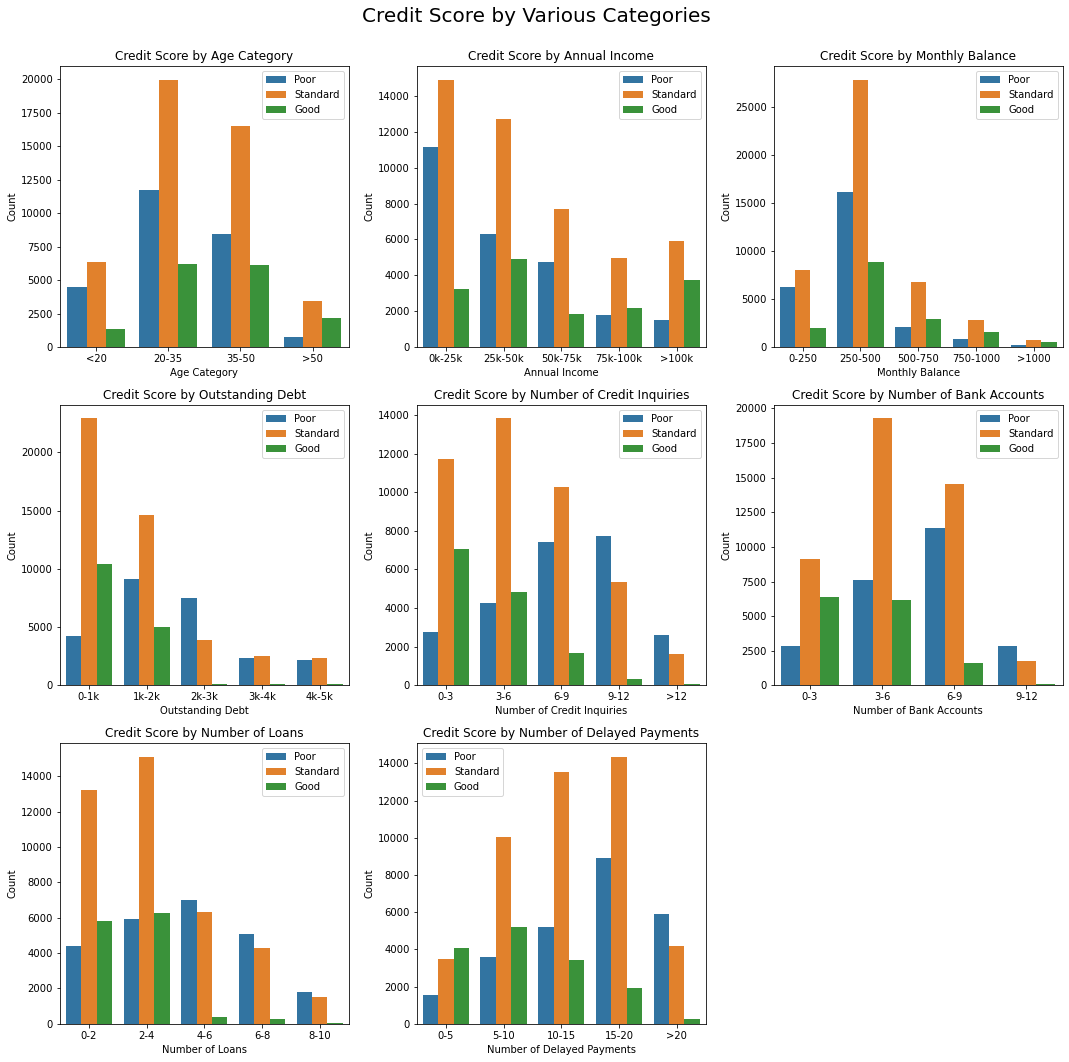

In [9]:
# Define the age bins and labels
age_bins = [0, 20, 35, 50, 100]
age_labels = ['<20', '20-35', '35-50', '>50']

# Define the bins and labels for each column
income_bins = [0, 25000, 50000, 75000, 100000,  10000000]
income_labels = ['0k-25k', '25k-50k', '50k-75k', '75k-100k','>100k']

balance_bins = [0, 250, 500, 750, 1000, 1000000]
balance_labels = ['0-250', '250-500', '500-750', '750-1000', '>1000']

debt_bins = [0, 1000, 2000, 3000, 4000, 5000]
debt_labels = ['0-1k', '1k-2k', '2k-3k', '3k-4k', '4k-5k']

inquiries_bins = [0, 3, 6, 9, 12, 1000]
inquiries_labels = ['0-3', '3-6', '6-9', '9-12', '>12']

bank_acct_bins = [0, 3, 6, 9, 12]
bank_acct_labels = ['0-3', '3-6', '6-9', '9-12']

loan_bins = [0, 2, 4, 6, 8, 10]
loan_labels = ['0-2', '2-4', '4-6', '6-8', '8-10']

delayed_bins = [0, 5, 10, 15, 20, 30]
delayed_labels = ['0-5', '5-10', '10-15', '15-20', '>20']

# Create the age category column
df2['Age_Category'] = pd.cut(df['Age'], bins=age_bins, labels=age_labels)
df2['Income_Category'] = pd.cut(df['Annual_Income'], bins=income_bins, labels=income_labels)
df2['Balance_Category'] = pd.cut(df['Monthly_Balance'], bins=balance_bins, labels=balance_labels)
df2['Debt_Category'] = pd.cut(df['Outstanding_Debt'], bins=debt_bins, labels=debt_labels)
df2['Inquiries_Category'] = pd.cut(df['Num_Credit_Inquiries'], bins=inquiries_bins, labels=inquiries_labels)
df2['Banks_Category'] = pd.cut(df['Num_Bank_Accounts'], bins=bank_acct_bins, labels=bank_acct_labels)
df2['Loan_Category'] = pd.cut(df['Num_of_Loan'], bins=loan_bins, labels=loan_labels)
df2['Delayed_Category'] = pd.cut(df['Num_of_Delayed_Payment'], bins=delayed_bins, labels=delayed_labels)

# Create subplots for the 7 different plots
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(15, 15))

# Create the count plots for each column and subcategory, and add them to the appropriate subplot
sns.countplot(x='Age_Category', hue='Credit_Score', data=df2, ax=axes[0, 0], order=age_labels)
sns.countplot(x='Income_Category', hue='Credit_Score', data=df2, ax=axes[0, 1], order=income_labels)
sns.countplot(x='Balance_Category', hue='Credit_Score', data=df2, ax=axes[0, 2], order=balance_labels)
sns.countplot(x='Debt_Category', hue='Credit_Score', data=df2, ax=axes[1, 0], order=debt_labels)
sns.countplot(x='Inquiries_Category', hue='Credit_Score', data=df2, ax=axes[1, 1], order=inquiries_labels)
sns.countplot(x='Banks_Category', hue='Credit_Score', data=df2, ax=axes[1, 2], order=bank_acct_labels)
sns.countplot(x='Loan_Category', hue='Credit_Score', data=df2, ax=axes[2, 0], order=loan_labels)
sns.countplot(x='Delayed_Category', hue='Credit_Score', data=df2, ax=axes[2, 1], order=delayed_labels)

# Remove the last subplot
fig.delaxes(axes[2, 2])

# Add titles and axis labels to each subplot
axes[0, 0].set_title('Credit Score by Age Category')
axes[0, 0].set_xlabel('Age Category')
axes[0, 0].set_ylabel('Count')
axes[0, 0].legend()

axes[0, 1].set_title('Credit Score by Annual Income')
axes[0, 1].set_xlabel('Annual Income')
axes[0, 1].set_ylabel('Count')
axes[0, 1].legend()

axes[0, 2].set_title('Credit Score by Monthly Balance')
axes[0, 2].set_xlabel('Monthly Balance')
axes[0, 2].set_ylabel('Count')
axes[0, 2].legend()

axes[1, 0].set_title('Credit Score by Outstanding Debt')
axes[1, 0].set_xlabel('Outstanding Debt')
axes[1, 0].set_ylabel('Count')
axes[1, 0].legend()

axes[1, 1].set_title('Credit Score by Number of Credit Inquiries')
axes[1, 1].set_xlabel('Number of Credit Inquiries')
axes[1, 1].set_ylabel('Count')
axes[1, 1].legend()

axes[1, 2].set_title('Credit Score by Number of Bank Accounts')
axes[1, 2].set_xlabel('Number of Bank Accounts')
axes[1, 2].set_ylabel('Count')
axes[1, 2].legend()

axes[2, 0].set_title('Credit Score by Number of Loans')
axes[2, 0].set_xlabel('Number of Loans')
axes[2, 0].set_ylabel('Count')
axes[2, 0].legend()

axes[2, 1].set_title('Credit Score by Number of Delayed Payments')
axes[2, 1].set_xlabel('Number of Delayed Payments')
axes[2, 1].set_ylabel('Count')
axes[2, 1].legend()

# Add a title to the overall plot
fig.suptitle('Credit Score by Various Categories', fontsize=20)

# Adjust the spacing between the subplots
fig.tight_layout(rect=[0, 0, 1, 0.95])

# Show the plot
plt.show()


In [10]:
df.head()

,ID,Customer_ID,Month,Name,Age,SSN,Occupation,Annual_Income,Monthly_Inhand_Salary,Num_Bank_Accounts,...,Credit_Mix,Outstanding_Debt,Credit_Utilization_Ratio,Credit_History_Age,Payment_of_Min_Amount,Total_EMI_per_month,Amount_invested_monthly,Payment_Behaviour,Monthly_Balance,Credit_Score
0,5634,3392,1,Aaron Maashoh,23.0,821000265.0,Scientist,19114.12,1824.843333,3.0,...,Good,809.98,26.822620,265.0,No,49.574949,21.46538,High_spent_Small_value_payments,312.494089,Good
1,5635,3392,2,Aaron Maashoh,23.0,821000265.0,Scientist,19114.12,1824.843333,3.0,...,Good,809.98,31.944960,266.0,No,49.574949,21.46538,Low_spent_Large_value_payments,284.629162,Good
2,5636,3392,3,Aaron Maashoh,23.0,821000265.0,Scientist,19114.12,1824.843333,3.0,...,Good,809.98,28.609352,267.0,No,49.574949,21.46538,Low_spent_Medium_value_payments,331.209863,Good
3,5637,3392,4,Aaron Maashoh,23.0,821000265.0,Scientist,19114.12,1824.843333,3.0,...,Good,809.98,31.377862,268.0,No,49.574949,21.46538,Low_spent_Small_value_payments,223.451310,Good
4,5638,3392,5,Aaron Maashoh,23.0,821000265.0,Scientist,19114.12,1824.843333,3.0,...,Good,809.98,24.797347,269.0,No,49.574949,21.46538,High_spent_Medium_value_payments,341.489231,Good


## Machine Learning Algorithms - Classification

In [11]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.svm import SVC
from sklearn.ensemble import GradientBoostingClassifier

### Preprocessing

In [12]:
# Preprocessing
le = LabelEncoder()

# Encoding categorical variables
df['Name'] = le.fit_transform(df['Name'])
df['Occupation'] = le.fit_transform(df['Occupation'])
df['Type_of_Loan'] = le.fit_transform(df['Type_of_Loan'])
df['Credit_Mix'] = le.fit_transform(df['Credit_Mix'])
df['Payment_of_Min_Amount'] = le.fit_transform(df['Payment_of_Min_Amount'])
df['Payment_Behaviour'] = le.fit_transform(df['Payment_Behaviour'])

In [13]:
# Splitting the dataset into train and test sets
X = df.drop(['ID', 'Customer_ID', 'Credit_Score'], axis=1)
y = df['Credit_Score']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

### Decision Tree Classifier

A decision tree classifier is a tree-like model where each internal node represents a decision based on a certain feature, and each leaf node represents a class label. The decision tree algorithm splits the data into sub-groups based on the most significant features, with the goal of creating homogeneous groups that have the same class label. This process continues recursively until a stopping criterion is met. Once the decision tree is built, it can be used to classify new data by traversing the tree and making decisions based on the feature values.

In [14]:
# Decision Tree Classifier
dt = DecisionTreeClassifier()
dt.fit(X_train, y_train)
y_pred_dt = dt.predict(X_test)

# Evaluation
print("Decision Tree Accuracy: ", accuracy_score(y_test, y_pred_dt))

Decision Tree Accuracy:  0.7427


### Random Forest Classifier

a random forest classifier is an ensemble learning method that constructs multiple decision trees and combines them to make a final prediction. The algorithm creates multiple decision trees, each with a random subset of the features and a random subset of the training data. These trees are then combined through a voting mechanism to make the final prediction. The main idea behind the random forest algorithm is that the combined decision of multiple trees will be more accurate than the decision of any individual tree.

In [15]:
# Random Forest Classifier
rf = RandomForestClassifier()
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)

# Evaluation
print("Random Forest Accuracy: ", accuracy_score(y_test, y_pred_rf))

Random Forest Accuracy:  0.8342333333333334


### Classification Report - Decision Trees vs Random Forest

In [16]:
print("Decision Tree Classification Report: \n", classification_report(y_test, y_pred_dt))
print("Random Forest Classification Report: \n", classification_report(y_test, y_pred_rf))

Decision Tree Classification Report: 
               precision    recall  f1-score   support

        Good       0.70      0.68      0.69      5322
        Poor       0.73      0.73      0.73      8805
    Standard       0.76      0.77      0.77     15873

    accuracy                           0.74     30000
   macro avg       0.73      0.73      0.73     30000
weighted avg       0.74      0.74      0.74     30000

Random Forest Classification Report: 
               precision    recall  f1-score   support

        Good       0.80      0.81      0.81      5322
        Poor       0.81      0.86      0.84      8805
    Standard       0.86      0.83      0.84     15873

    accuracy                           0.83     30000
   macro avg       0.83      0.83      0.83     30000
weighted avg       0.83      0.83      0.83     30000



**Precision:** Measures the proportion of correctly predicted positive instances out of all instances predicted as positive.

**Recall:** It is the ratio of true positive predictions to the sum of true positive and false negative predictions. It measures the proportion of correctly predicted positive instances out of all actual positive instances.

**F1-score:** -The F1-score balances both precision and recall, giving equal importance to both. The F1-score ranges from 0 (worst) to 1 (best).

*For each algorithm:*

**Decision Tree:**
- Good: Precision is 0.70, recall is 0.68, F1-score is 0.69, and support is 5322.
- Poor: Precision is 0.73, recall is 0.73, F1-score is 0.73, and support is 8805.
- Standard: Precision is 0.77, recall is 0.77, F1-score is 0.77, and support is 15873.

**Random Forest:**
- Good: Precision is 0.80, recall is 0.80, F1-score is 0.80, and support is 5322.
- Poor: Precision is 0.81, recall is 0.86, F1-score is 0.83, and support is 8805.
- Standard: Precision is 0.85, recall is 0.83, F1-score is 0.84, and support is 15873.

Random forests have several advantages over decision trees. They are less prone to overfitting and can handle a larger number of features. Additionally, they provide a measure of feature importance, which can be useful in feature selection. However, they can be slower to train than decision trees due to the creation of multiple trees.

***As mentioned above, these results are expected. Therefore below I will explore more complex algorithms:***

### Gradient Boosting Classifier

Gradient Boosting Classifier is an ensemble learning method that works by combining multiple weak learners (decision trees) to create a strong learner. It builds the model in a stage-wise fashion, where each subsequent model focuses on the errors made by the previous models. Gradient Boosting Classifier can perform well in cases where the data has high variance or noise, as it can reduce overfitting by combining multiple weak models.

In [17]:
# Gradient Boosting Classifier
gbc = GradientBoostingClassifier()
gbc.fit(X_train, y_train)
y_pred_gbc = gbc.predict(X_test)

# Evaluation
print("Gradient Boosting Classifier Accuracy: ", accuracy_score(y_test, y_pred_gbc))
print("Gradient Boosting Classifier Classification Report: \n", classification_report(y_test, y_pred_gbc))

Gradient Boosting Classifier Accuracy:  0.713
Gradient Boosting Classifier Classification Report: 
               precision    recall  f1-score   support

        Good       0.59      0.70      0.64      5322
        Poor       0.74      0.65      0.69      8805
    Standard       0.75      0.75      0.75     15873

    accuracy                           0.71     30000
   macro avg       0.69      0.70      0.69     30000
weighted avg       0.72      0.71      0.71     30000



Compared to Random Forest, Gradient Boosting Classifier builds trees sequentially, focusing on the errors made by previous trees, while Random Forest builds multiple trees independently and combines their results through averaging or majority voting. Gradient Boosting can sometimes outperform Random Forest when the data has high variance, but it might be more prone to overfitting if not tuned properly.

## Comparison of Algorithms:

In [18]:
print("Decision Tree Classification Report: \n", classification_report(y_test, y_pred_dt))
print("Random Forest Classification Report: \n", classification_report(y_test, y_pred_rf))
print("Gradient Boosting Classifier Classification Report: \n", classification_report(y_test, y_pred_gbc))

Decision Tree Classification Report: 
               precision    recall  f1-score   support

        Good       0.70      0.68      0.69      5322
        Poor       0.73      0.73      0.73      8805
    Standard       0.76      0.77      0.77     15873

    accuracy                           0.74     30000
   macro avg       0.73      0.73      0.73     30000
weighted avg       0.74      0.74      0.74     30000

Random Forest Classification Report: 
               precision    recall  f1-score   support

        Good       0.80      0.81      0.81      5322
        Poor       0.81      0.86      0.84      8805
    Standard       0.86      0.83      0.84     15873

    accuracy                           0.83     30000
   macro avg       0.83      0.83      0.83     30000
weighted avg       0.83      0.83      0.83     30000

Gradient Boosting Classifier Classification Report: 
               precision    recall  f1-score   support

        Good       0.59      0.70      0.64      53

In [ ]:
import matplotlib.pyplot as plt

# Get the f1-scores for each class and model
dt_f1 = classification_report(y_test, dt_pred, output_dict=True)
rf_f1 = classification_report(y_test, rf_pred, output_dict=True)
# gb_f1 = classification_report(y_test, gb_pred, output_dict=True)

# Extract f1-scores for each class
labels = ['Good', 'Poor', 'Standard']
dt_scores = [dt_f1[label]['f1-score'] for label in labels]
rf_scores = [rf_f1[label]['f1-score'] for label in labels]
# gb_scores = [gb_f1[label]['f1-score'] for label in labels]

# Plot the bar chart
x = np.arange(len(labels))
width = 0.25

fig, ax = plt.subplots()
rects1 = ax.bar(x - width, dt_scores, width, label='Decision Tree')
rects2 = ax.bar(x, rf_scores, width, label='Random Forest')
# rects3 = ax.bar(x + width, gb_scores, width, label='Gradient Boosting')

ax.set_ylabel('F1-Score')
ax.set_title('F1-Score by Class and Algorithm')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

fig.tight_layout()
plt.show()

Here we will explore how these algorithms differ, based on the data. Below we will explore the pro / cons of each algorithm, and how they differ in regards to overfitiing, noise and class distribution. 

**Decision Trees:**
Decision Trees are a non-parametric method that recursively splits the feature space based on the features that provide the highest information gain or the lowest impurity (e.g., Gini impurity or entropy). The tree grows until a stopping criterion is met, such as reaching a maximum depth or minimum samples per leaf. 

- ***Overfitting:*** Decision Trees are prone to overfitting, especially when they are deep, because they can perfectly fit the training data by creating overly complex decision boundaries. Overfitting leads to poor generalization performance on unseen data.

- ***Noise:*** Decision Trees can be sensitive to noise in the data, as even small changes in the input data might lead to completely different tree structures. This sensitivity makes them less robust in handling noisy data.

- ***Class Distributions:*** Decision Trees can handle imbalanced class distributions reasonably well, as they can create decision boundaries that separate minority classes from majority classes. However, in the presence of severe class imbalance, the model might still be biased towards the majority class.

**Random Forests:**
Random Forests are an ensemble method that combines multiple decision trees, built independently from each other. During the construction of each tree, a random subset of the training data and features is selected, which introduces diversity in the forest. The final prediction is obtained by averaging (for regression) or majority voting (for classification) the predictions of the individual trees.

- ***Overfitting:*** Random Forests help mitigate overfitting by averaging the predictions of multiple trees. The diverse set of trees, each trained on a different subset of data and features, reduces the overall model's complexity and provides a more generalized decision boundary.

- ***Noise:*** Random Forests are more robust to noise than single decision trees, as the ensemble's averaging effect reduces the impact of noise present in individual trees. However, Random Forests can still be maffected by noise when the noise level is high.

- ***Class Distributions:*** Random Forests can handle imbalanced class distributions by adjusting the class weights or using techniques like bootstrapping, which can create a more balanced representation of the classes during the training process. However, severe class imbalance might still lead to biased predictions towards the majority class.

**Gradient Boosting Classifier:**
Gradient Boosting Classifier is another ensemble method that combines multiple weak learners (usually shallow decision trees) in a stage-wise fashion. It starts with a simple initial model and iteratively improves it by adding new weak learners that focus on the errors made by the previous models.

- ***Overfitting:*** Gradient Boosting Classifier can control overfitting by using shallow trees as weak learners and by limiting the number of boosting iterations. However, if the model is not well-tuned, overfitting can still occur, especially when the learning rate is high, or the number of boosting iterations is excessive.

- ***Noise:*** Gradient Boosting Classifier can handle noisy data to some extent, as it focuses on the errors made by previous models during the boosting process. However, if the noise level is high, the algorithm might end up fitting the noise, resulting in overfitting and poor generalization performance.

- ***Class Distributions:*** Gradient Boosting Classifier can handle imbalanced class distributions by adjusting the loss function or using techniques like sample weighting or cost-sensitive learning. However, it might still struggle with severe class imbalance, which can lead to biased predictions.

The performance differences among the three algorithms can be attributed to their underlying theories related to overfitting, noise, and class distributions, and are explored above. Random Forests perform the best in this problem because they effectively mitigate overfitting and handle noise better by averaging the predictions of multiple decision trees, leading to a more accurate and stable model. Gradient Boosting Classifier can also perform well when tuned correctly, but it might be more sensitive to noise and overfitting depending on the learning rate and number of boosting iterations. Decision Trees, while simple and easy to understand, tend to suffer from overfitting and are less robust to noise compared to the ensemble methods.

***Overall, the choice of the algorithm depends on the specific problem and the characteristics of the dataset. Below, we will try to improve the algorithms above.***

## Improving ML Algorithms - Hyperparamer Tuning

**Decision Tree:** Key hyperparameters:
- ***max_depth:*** The maximum depth of the tree. Deeper trees can lead to overfitting, while shallow trees might result in underfitting.
- ***min_samples_split:*** The minimum number of samples required to split an internal node. Larger values result in a more regularized model.
- ***min_samples_leaf:*** The minimum number of samples required to be at a leaf node. Larger values can help prevent overfitting.

**Random Forest:** Key hyperparameters:
- ***n_estimators:*** The number of trees in the forest. Increasing this value generally improves the model's performance but also increases the computational cost.
- ***max_depth:*** The maximum depth of each tree in the forest. Similar to Decision Trees, controlling the depth helps in balancing bias and variance.
- ***min_samples_split and min_samples_leaf:*** These parameters have the same meaning as in Decision Trees and help in regularizing the model.

**Gradient Boosting Classifier:** Key hyperparameters:
- ***n_estimators:*** The number of boosting stages to perform. A larger number of estimators can improve performance but may lead to overfitting.
- ***learning_rate:*** The rate at which the model learns from the errors of previous iterations. A smaller learning rate requires more iterations but can result in a more accurate model.
- max_depth: The maximum depth of the individual trees. Similar to Decision Trees, controlling the depth helps in balancing bias and variance.
- ***subsample:*** The fraction of samples to be used for fitting the individual base learners. Using a smaller subsample value introduces randomness and can help in reducing overfitting.

In [19]:
from sklearn.model_selection import RandomizedSearchCV

Both GridSearchCV and RandomizedSearchCV are techniques used in hyperparameter tuning of machine learning models. The key difference between them is the way in which they search the hyperparameter space.

- **GridSearchCV** performs an exhaustive search over a predefined set of hyperparameters. It generates all possible combinations of hyperparameters and evaluates the model for each combination. This approach can be effective for small hyperparameter spaces, but can quickly become computationally expensive for large hyperparameter spaces.

- **RandomizedSearchCV**, on the other hand, performs a randomized search over the hyperparameter space. It generates a fixed number of random combinations of hyperparameters and evaluates the model for each combination. This approach can be more efficient for large hyperparameter spaces and can often find good hyperparameter combinations faster than GridSearchCV.

***In this project I attempted GridSearchCV, but it proved too computationally expensive.***

In [20]:
# Decision Tree
dt_params = {
    'max_depth': [10, 20, 30, 40, 50, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'criterion': ['gini', 'entropy']
}

dt_random_search = RandomizedSearchCV(
    estimator=DecisionTreeClassifier(),
    param_distributions=dt_params,
    n_iter=50,
    cv=3,
    verbose=2,
    random_state=42,
    n_jobs=-1
)

# Random Forest
rf_params = {
    'n_estimators': [100, 200, 300],
    'max_depth': [10, 20, 30, 40, 50, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True, False]
}

rf_random_search = RandomizedSearchCV(
    estimator=RandomForestClassifier(),
    param_distributions=rf_params,
    n_iter=50,
    cv=3,
    verbose=2,
    random_state=42,
    n_jobs=-1
)

# Gradient Boosting Classifier
#gb_params = {
#    'n_estimators': [100, 200, 300],
#   'learning_rate': [0.01, 0.1, 0.2],
#    'max_depth': [3, 5, 10, 20],
#    'min_samples_split': [2, 5, 10],
#    'min_samples_leaf': [1, 2, 4],
#    'subsample': [0.5, 0.75, 1.0],
#    'max_features': ['auto', 'sqrt', 'log2']
#}

#gb_random_search = RandomizedSearchCV(
#    estimator=GradientBoostingClassifier(),
#    param_distributions=gb_params,
#    n_iter=50,
#    cv=3,
#    verbose=2,
#    random_state=42,
#    n_jobs=-1
#)

# Fit the random search models
dt_random_search.fit(X_train, y_train)
rf_random_search.fit(X_train, y_train)
#gb_random_search.fit(X_train, y_train)

# Print the best parameters for each model
print("Best Decision Tree Parameters: ", dt_random_search.best_params_)
print("Best Random Forest Parameters: ", rf_random_search.best_params_)
#print("Best Gradient Boosting Parameters: ", gb_random_search.best_params_)


Fitting 3 folds for each of 50 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    6.8s
[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:   31.8s finished


Fitting 3 folds for each of 50 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed: 10.1min finished


Best Decision Tree Parameters:  {'min_samples_split': 2, 'min_samples_leaf': 1, 'max_depth': 20, 'criterion': 'gini'}
Best Random Forest Parameters:  {'n_estimators': 300, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_depth': 50, 'bootstrap': False}


In [22]:
# Get the best models
best_dt = dt_random_search.best_estimator_
best_rf = rf_random_search.best_estimator_
# best_gb = gb_random_search.best_estimator_

# Predict with the best models
dt_pred = best_dt.predict(X_test)
rf_pred = best_rf.predict(X_test)
# gb_pred = best_gb.predict(X_test)

# Classification reports
print("Decision Tree Classification Report:")
print(classification_report(y_test, dt_pred))

print("Random Forest Classification Report:")
print(classification_report(y_test, rf_pred))

print("Gradient Boosting Classifier Classification Report:")
# print(classification_report(y_test, gb_pred))

Decision Tree Classification Report:
              precision    recall  f1-score   support

        Good       0.66      0.68      0.67      5322
        Poor       0.74      0.71      0.72      8805
    Standard       0.76      0.78      0.77     15873

    accuracy                           0.74     30000
   macro avg       0.72      0.72      0.72     30000
weighted avg       0.74      0.74      0.74     30000

Random Forest Classification Report:
              precision    recall  f1-score   support

        Good       0.82      0.82      0.82      5322
        Poor       0.82      0.86      0.84      8805
    Standard       0.86      0.83      0.85     15873

    accuracy                           0.84     30000
   macro avg       0.83      0.84      0.83     30000
weighted avg       0.84      0.84      0.84     30000

Gradient Boosting Classifier Classification Report:


In [23]:
print("Best Decision Tree Parameters: ", dt_random_search.best_params_)
print("Best Random Forest Parameters: ", rf_random_search.best_params_)
# print("Best Gradient Boosting Parameters: ", gb_random_search.best_params_)

Best Decision Tree Parameters:  {'min_samples_split': 2, 'min_samples_leaf': 1, 'max_depth': 20, 'criterion': 'gini'}
Best Random Forest Parameters:  {'n_estimators': 300, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_depth': 50, 'bootstrap': False}


***Important to Note - I removed the gradient boosting in the code and made them invisible since running GB with randomizedSearchCV took over an hour to solve. However the performance was not as impressive as Random Forest***

### Comparing these Results:

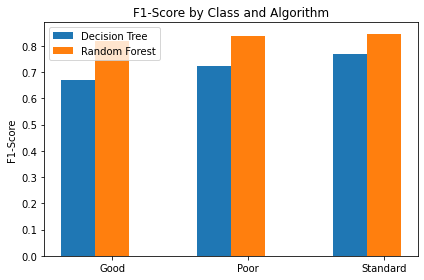

In [25]:
import matplotlib.pyplot as plt

# Get the f1-scores for each class and model
dt_f1 = classification_report(y_test, dt_pred, output_dict=True)
rf_f1 = classification_report(y_test, rf_pred, output_dict=True)
# gb_f1 = classification_report(y_test, gb_pred, output_dict=True)

# Extract f1-scores for each class
labels = ['Good', 'Poor', 'Standard']
dt_scores = [dt_f1[label]['f1-score'] for label in labels]
rf_scores = [rf_f1[label]['f1-score'] for label in labels]
# gb_scores = [gb_f1[label]['f1-score'] for label in labels]

# Plot the bar chart
x = np.arange(len(labels))
width = 0.25

fig, ax = plt.subplots()
rects1 = ax.bar(x - width, dt_scores, width, label='Decision Tree')
rects2 = ax.bar(x, rf_scores, width, label='Random Forest')
# rects3 = ax.bar(x + width, gb_scores, width, label='Gradient Boosting')

ax.set_ylabel('F1-Score')
ax.set_title('F1-Score by Class and Algorithm')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

fig.tight_layout()
plt.show()

## Possible Future Directions

### Neural Networks

***Pros of Neural Networks:***
- Neural networks can capture complex patterns in the data and are especially good at handling non-linear relationships.
- They can automatically learn and model feature interactions without the need for explicit feature engineering.
- They can be highly accurate if properly tuned and trained on large datasets.

***Cons of Neural Networks:***
- Neural networks can be computationally expensive and may take a long time to train, especially on large datasets.
- They are more sensitive to the quality and quantity of data, often requiring large amounts of labeled data to perform well.
- They can be prone to overfitting, especially when the model architecture is too complex.
- They are often considered "black boxes" due to the difficulty of interpreting and understanding the internal workings of the model.

### Other Possible Directions

- **Proffesional Expertise** - Leveraging domain knowledge to prioritize the most informative samples for annotation and model training. This would mean using a financial advisor to determine which features are more important; or what feature are missing and should be added to algorithm.


- **Regression model** - Unfortunately, the data did not have the credit score in a numerical form. Instead, it's a classification system that sorts individuals into [Poor, Standard, Good]. Using a regression model to predict the numerical credit score, and then classifying the credit score can be an interesting approach. By predicting the exact credit score value first, you might capture more information about the underlying distribution and relationships in the data. After obtaining the predicted credit score, you can set thresholds to classify it into the categories [Poor, Standard, Good]. This approach could potentially improve the performance of the model, especially if the relationships between the features and the credit score are more linear in nature. 

# Conclusion

In this project, we aimed to classify credit scores into three categories: Good, Poor, and Standard. We started by implementing three classification algorithms: Decision Tree, Random Forest, and Gradient Boosting Classifier. We evaluated their performance using classification reports, which provided precision, recall, f1-score, and accuracy metrics for each algorithm. Although Random Forest performed fairly well; we can improve it. Next, we used RandomizedSearchCV to perform hyperparameter tuning on these three algorithms, aiming to improve their performance. We compared their performance after tuning and observed improvements in the metrics for each algorithm compared to their default parameters.

In the future, we can use more advanced algorithms, however to fully utilize their benefits we would need more data to improve the performance of these models. We implemented a Neural Network algorithm as an alternative approach to classify credit scores. We discussed its pros and cons and potential directions to improve the performance of this project further.

Overall, the Random Forest and Gradient Boosting Classifier generally showed better performance than the Decision Tree algorithm. The choice of the most suitable technique depends on the specific requirements and constraints of the project, such as computational resources, prediction speed, and interpretability. However, as mentioned their is a lot more to improve, such as feature engineering, amount of data utilized, and complexity of algorithms. To find the best performing model we should also utilize GridSearchCV if their was enough computational power and time. 